In [1]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import model_utils

from torchvision.models import vgg16
import torch.nn as nn
%matplotlib inline

In [2]:
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [10]:
bs = 16
sz = (320,240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImg(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

In [11]:
ds = NYUDataset('data/', tfms)

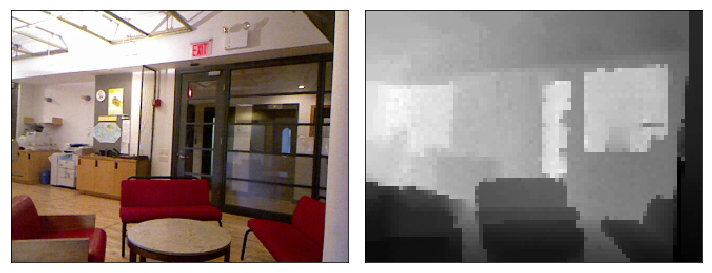

In [20]:
plot_utils.plot_image(unnormalize(ds[250]))

In [13]:
dl = torch.utils.data.DataLoader(ds, bs)

In [10]:
sample_batch = iter(dl).next()
img, depth = sample_batch

In [11]:
depth.shape

torch.Size([16, 60, 80])

In [22]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, batch):
        return batch.view([batch.shape[0], -1])
    
class Scale1_Linear(nn.Module):
    #input 512x7x10
    #output 64x15x20
    
    def __init__(self):
        super(Scale1_Linear, self).__init__()
        self.block = nn.Sequential(
            Flatten(),
            nn.Linear(512*7*10, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 64*15*20)
        )
    
    def forward(self, x):
        scale_1_op = torch.reshape(self.block(x), (x.shape[0], 64, 15, 20))
        return nn.functional.interpolate(scale_1_op, scale_factor=4, mode='bilinear')
    
class Scale2(nn.Module):
    #input 64x60x80, 3x240x320
    #output 1x120x160
        
    def __init__(self):
        super(Scale2, self).__init__()
        self.input_img_proc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=64+64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2) 
        )
    
    def forward(self, x, input_img): 
        proc_img = self.input_img_proc(input_img)
        concatenate_input = torch.cat((x,proc_img), dim=1)
        return nn.functional.interpolate(self.block(concatenate_input), scale_factor=2, mode='bilinear')      
        
    
class Scale3(nn.Module):
    #input 1x120x160, 3x240x320
    #output 1x120x160
    
    def __init__(self):
        super(Scale3, self).__init__()
        self.input_img_proc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=65, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
        )
    
    def forward(self, x, input_img): 
        proc_img = self.input_img_proc(input_img)
        concatenate_input = torch.cat((x,proc_img), dim=1)
        return self.block(concatenate_input)  
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.VGG = nn.Sequential(*list(vgg16(pretrained=True).children())[0])
        self.Scale_1 = Scale1_Linear()
        self.Scale_2 = Scale2()
        self.Scale_3 = Scale3()
        
    def forward(self, x):
        input_img = x.clone()                  # 3x240x320
        x = self.VGG(x)                        # 512x7x10
        x = self.Scale_1(x)                    # 64x60x80
        #x = self.Scale_2(x, input_img.clone()) # 1x120x160
        #x = self.Scale_3(x, input_img.clone()) # 1x120x160
        return x

In [23]:
model = Net()
model_utils.freeze_all_layers(model.VGG)
model(torch.ones((1,3,240,320))).shape

/Users/dhruv/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 64, 60, 80])

In [ ]:
#training
#choose optimizer, iterate over mini batches from data loader

#n_epochs = 5
#adam, lr = 0.001